In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from keras.optimizers import Adam, SGD, Adadelta

In [2]:
x_train_scaled = pd.read_csv('260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,LOC645195,RPS20P18,RPS6KB2,ERP29P1,MORF4L1P5,AQP4,LOC100421816,KRTAP10_9,TAAR1,PRR14
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.000000,0.0,0.331508,0.0,0.0,0.556399,0.0,1.0,0.0,0.652264
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.497909,0.0,0.249089,0.0,0.0,0.153238,0.0,0.0,0.0,0.357332
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.000000,0.0,0.491080,0.0,0.0,0.000000,0.0,0.0,0.0,0.757276
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.000000,0.0,0.231208,0.0,0.0,0.133847,0.0,0.0,0.0,0.465784
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.000000,0.0,0.146162,0.0,0.0,0.000000,0.0,0.0,0.0,0.372143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.000000,0.0,0.113124,0.0,0.0,1.000000,0.0,0.0,0.0,0.069245
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.000000,0.0,0.248849,0.0,0.0,0.181338,0.0,0.0,0.0,0.503636
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.000000,0.0,0.194293,0.0,0.0,0.000000,0.0,0.0,0.0,0.510238


In [3]:
x_test_scaled = pd.read_csv('260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,LOC645195,RPS20P18,RPS6KB2,ERP29P1,MORF4L1P5,AQP4,LOC100421816,KRTAP10_9,TAAR1,PRR14
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.000000,0.0,0.341197,0.0,0.0,0.000000,0.0,0.0,0.0,0.554593
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.052435,0.0,0.509297,0.0,0.0,0.016138,0.0,0.0,0.0,0.694058
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.000000,0.0,0.225855,0.0,0.0,0.640920,0.0,0.0,0.0,0.399227
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.000000,0.0,0.294898,0.0,0.0,0.086569,0.0,0.0,0.0,0.454726
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.000000,0.0,0.154352,0.0,0.0,0.212885,0.0,0.0,0.0,0.444811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.000000,0.0,0.245997,0.0,0.0,0.000000,0.0,0.0,0.0,0.416223
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.788932,0.0,0.151514,0.0,0.0,0.000000,0.0,0.0,0.0,0.089703
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.344819,0.0,0.152747,0.0,0.0,0.192687,0.0,0.0,0.0,0.482958


In [4]:
sh = x_train_scaled.head(1).shape

In [5]:


# class AutoEncoder(Model):

#     def __init__(self, n_inputs, init_fn, n_bottleneck=32):

#         super().__init__()

#         self.encoder = Sequential(
#             [

#                 Input(shape=(n_inputs,)),
#                 # encoder level 1
#                 Dense(n_inputs*2, kernel_initializer=init_fn,
#     bias_initializer=initializers.Zeros()),
#                 BatchNormalization(),
#                 LeakyReLU(),
#                 # encoder level 2
#                 Dense(n_inputs),
#                 BatchNormalization(),
#                 LeakyReLU(),
#                 # bottleneck
#                 Dense(n_bottleneck)
#             ]
#         )



#     def call(self, inputs):

#         encoded = self.encoder(inputs)
#         return encoded

In [6]:
# n_bottleneck = 32
# initializer = tf.keras.initializers.GlorotUniform()
# auto_encoder = AutoEncoder(219,initializer, n_bottleneck)

In [7]:
# auto_encoder.encoder.load_weights("encoder_ckpt")

In [8]:
# auto_encoder.build(sh) 
# auto_encoder.summary()

In [9]:
# auto_encoder.encoder.summary()

In [10]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [11]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [12]:
class Classifier(Model):

    def __init__(self, n_inputs, init_fn, n_bottleneck=32):

        super().__init__()

        self.encoder = Sequential(
            [

                Input(shape=(n_inputs,)),
                # encoder level 1
                Dense(n_inputs*2, kernel_initializer=init_fn,
    bias_initializer=initializers.Zeros()),
                BatchNormalization(),
                LeakyReLU(),
                # encoder level 2
                Dense(n_inputs),
                BatchNormalization(),
                LeakyReLU(),
                # bottleneck
                Dense(n_bottleneck)
            ]
        )
        self.inter = Dense(24, activation='relu')
        self.final = Dense(3, activation='softmax')



    def call(self, inputs):

        encoded = self.encoder(inputs)
        clf = self.inter(encoded)
        clf = self.final(clf)
        return clf

In [13]:
n_bottleneck = 32
initializer = tf.keras.initializers.GlorotUniform()
classifier = Classifier(219,initializer, n_bottleneck)

In [14]:
classifier.encoder.load_weights("encoder_ckpt")

In [15]:
classifier.build(sh) 
classifier.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32)                202169    
                                                                 
 dense_3 (Dense)             multiple                  792       
                                                                 
 dense_4 (Dense)             multiple                  75        
                                                                 
Total params: 203,036
Trainable params: 201,722
Non-trainable params: 1,314
_________________________________________________________________


In [16]:
# classifier.encoder.trainable = False

In [17]:
classifier.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32)                202169    
                                                                 
 dense_3 (Dense)             multiple                  792       
                                                                 
 dense_4 (Dense)             multiple                  75        
                                                                 
Total params: 203,036
Trainable params: 201,722
Non-trainable params: 1,314
_________________________________________________________________


In [18]:
from keras.optimizers import Adam, SGD, Adadelta

opt = Adam(learning_rate=0.001)

classifier.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
history = classifier.fit(x_train_scaled, disease_labels_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 1s 3ms/step - loss: 1.2388 - accuracy: 0.4286
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6729 - accuracy: 0.7253
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5793 - accuracy: 0.7802
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4824 - accuracy: 0.8132
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.8297
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2998 - accuracy: 0.9121
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.9286
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2101 - accuracy: 0.9505
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1385 - accuracy: 0.9780
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1128 - accuracy: 0.9945
Epoch 11/100
6/6 [===========

6/6 [==============================] - 0s 2ms/step - loss: 9.1162e-04 - accuracy: 1.0000
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 9.3294e-04 - accuracy: 1.0000
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 8.7935e-04 - accuracy: 1.0000
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 1.0000
Epoch 94/100
6/6 [===

In [20]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


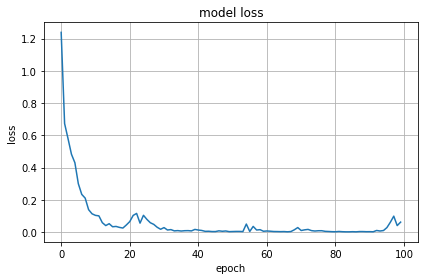

In [21]:
# summarize history for loss
plt.figure()
plt.grid()
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['Training', 'Validation'], loc='upper left')
plt.tight_layout()
# plt.savefig('autoencoder_learning_curve_loss.png', dpi=300)
plt.show()

In [22]:
test_loss, test_acc = classifier.evaluate(x_test_scaled, disease_labels_test, verbose=2)

print('\nTest accuracy:', test_acc)

3/3 - 0s - loss: 1.9471 - accuracy: 0.6795 - 119ms/epoch - 40ms/step

Test accuracy: 0.6794871687889099
